In [3]:
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
%matplotlib inline

#local imports
from detection_rate_main import detection_rate_main
from utils.mbhbinaries import MagicMergers, EvolveFDFA

from pyphenomd.pyphenomd import *
import scipy.constants as ct
Msun=1.989e30

## Declare Resample Parameters

In [20]:
num_catalogs = 10000
t_obs = 10.0 #years
duration = 100.0 #years

#input file
fp = '../data_ready_june_snap_lim_1.txt'

##################
###### KDE #######
##################

# what key for the input data for m1, m2. It is not
# needed for z because we calculate z_coalescence. 
kde_key_guide = OrderedDict()
kde_key_guide['m1'] = 'mass_new_prev_in'
kde_key_guide['m2'] = 'mass_new_prev_out'
#kde_key_guide['z'] = 'redshift'

########################
###### Evolution #######
########################

# evolve with Dosopoulou and Antonini 2017
evolve_class = EvolveFDFA
# keys are the parameter names for the evolution scenario. 
# values are the corresponding names of the input_data columns
evolve_key_guide = {'m1':'mass_new_prev_in', 'm2':'mass_new_prev_out', 
                    'z':'redshift', 'separation':'separation', 'gamma':'gamma', 
                    'vel_disp_1':'vel_disp_prev_in',  'vel_disp_2':'vel_disp_prev_out'}


# magic mergers
#evolve_key_guide = {'z':'redshift'}
#evolve_class = MagicMergers

###########################
###### merger rate  #######
###########################

# kwargs related to merger rate calculation
merger_rate_kwargs = {'Vc':106.5**3, 'dz':0.001, 'zmax':10.0}

############################################
###### Parrallel Calculation of SNRs #######
############################################
parallel_kwargs = {'num_processors':None, 'num_splits':1000, 'verbose':10}

## Run the Resampler

In [21]:
# only_detectable and snr_threshold are optional kwargs.
# only_detectable defaults to False which makes snr_threshold meaningless
# only_detectable True means the binaries returned have an SNR over the threshold
cats = detection_rate_main(num_catalogs, t_obs, duration, fp,
                            evolve_key_guide, kde_key_guide, evolve_class,
                            merger_rate_kwargs, parallel_kwargs, 
                            only_detectable=True, snr_threshold=8.0)

merger rate: 0.6194962953593661
numprocs 4
start pool with 4 processors: 619 total processes.

Start process: 9
Start process: 19
Start process: 29
Start process: 39
Start process: 49
Start process: 59
Start process: 69
Start process: 79
Start process: 89
Start process: 99
Start process: 109
Start process: 119
Start process: 129
Start process: 139
Start process: 149
Start process: 159
Start process: 169
Start process: 179
Start process: 189
Start process: 199
Start process: 209
Start process: 219
Start process: 229
Start process: 239
Start process: 249
Start process: 259
Start process: 269
Start process: 279
Start process: 289
Start process: 299
Start process: 309
Start process: 319
Start process: 329
Start process: 339
Start process: 349
Start process: 359
Start process: 369
Start process: 379
Start process: 389
Start process: 399
Start process: 409
Start process: 419
Start process: 429
Start process: 439
Start process: 449
Start process: 459
Start process: 469
Start process: 479
Star

/Users/michaelkatz/Documents/Research/Illustris/MCproject/paper/code/detection_rate_main.py:79: RuntimeWarning: invalid value encountered in greater
  inds_keep = np.where(snr>8.0)[0]


In [22]:
cats.dtype

dtype((numpy.record, [('cat', '<i8'), ('t_event', '<f8'), ('m1', '<f8'), ('m2', '<f8'), ('z_coal', '<f8'), ('snr', '<f8')]))

Text(0.5,0,'$\\log_{10}{\\rho}$')

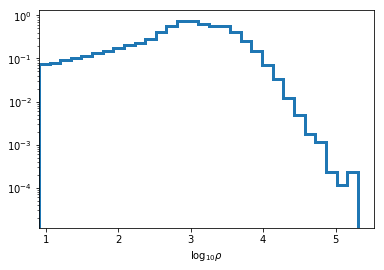

In [26]:
plt.hist(np.log10(cats['snr']), bins=30, histtype='step', lw=3, log=True, density=True)
plt.xlim(np.log10(8),)
plt.xlabel(r'$\log_{10}{\rho}$')

[2.68377761e-06 2.68661435e-06 2.68945408e-06 ... 2.02596930e-04
 2.02811073e-04 2.03025444e-04] [2.68334481e-06 7.13139255e-06 2.90075465e-05 1.18729624e-04]
[9.40103957e-06 9.40809589e-06 9.41515751e-06 ... 2.02721009e-04
 2.02873169e-04 2.03025444e-04] [9.39954595e-06 2.57253610e-05 1.12105829e-04 5.04826268e-04]


Text(0.5,0.05,'Frequency (Hz)')

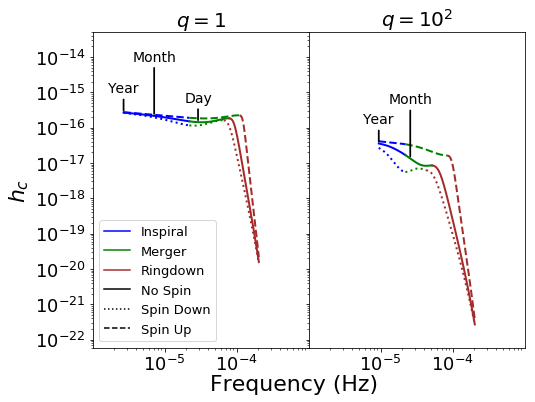

In [5]:
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
fig1.set_size_inches(8,6)
plt.subplots_adjust(wspace=0.0, left=0.15, bottom=0.15)

M = 1e8
z = 1.0
start_time = 1.0
end_time = 0.0
ax1.set_title(r'$q=1$', fontsize=20)
ax2.set_title(r'$q=10^{2}$', fontsize=20)
for q, ax in [[1, ax1], [1/100,ax2]]:
    ax.set_ylim(6e-23, 5e-14)
    ax.set_xlim(1e-6, 1e-3)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
    for s, ls in [[-0.8, 'dotted'], [0.0, 'solid'], [0.8,'dashed']]:
        m1 = M/(1+q)
        m2 = M*q/(1+q)
        wave = PhenomDWaveforms(m1, m2, s, s, z, start_time, end_time, num_points=4096)
        wave.create_waveforms()
        
        f = wave.freqs
        hc = wave.amplitude*np.sqrt(96/200) #averaging factor see Cornish and Robson 2018
        
        ins = np.where(f<wave.fmrg)[0]
        mrg = np.where((f>=wave.fmrg)&(f<=wave.fpeak))[0]
        rd = np.where(f>wave.fpeak)[0]
        
        ax.loglog(f[ins], hc[ins], color='blue', ls = ls, lw = 2)
        ax.loglog(f[mrg], hc[mrg], color='green', ls = ls, lw = 2)
        ax.loglog(f[rd], hc[rd], color='brown', ls = ls, lw = 2)
        if s == 0.0:
            N = m1*m2/(m1+m2)**2.
            start_times = np.array([1.0,1.0/12.0, 1.0/365.25,1.0/(365.25*24.0)])*ct.Julian_year/(1+z)

            tau = N*(start_times*ct.c)/(5.*(m1+m2)*Msun*ct.G/(ct.c**2.))
            flow = 1./(8.*ct.pi*(m1+m2)*Msun*ct.G/(ct.c**2.)*tau**(3./8.))*(1.+((11./32)*N+743./2688.)*tau**(-1./4.))*ct.c/(1+z)

            print(f, flow)
            try:
                f_1y_ind = np.where(f >= flow[0])[0][0]
            except IndexError:
                f_1y_ind = 0
            ax.annotate("Year",xy=(f[f_1y_ind], hc[f_1y_ind]), xycoords='data',xytext=(0, 20), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)  
            
            f_1m_ind = np.where(f >= flow[1])[0][0]
            ax.annotate("Month",xy=(f[f_1m_ind], hc[f_1m_ind]), xycoords='data',xytext=(0.0, 55), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)
            
            if q != 1/100:
                f_1d_ind = np.where(f >= flow[2])[0][0]
                ax.annotate("Day",xy=(f[f_1d_ind], hc[f_1d_ind]), xycoords='data',xytext=(0.0, 20), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)

ax1.plot(1,1, color='blue', ls='solid', label='Inspiral')
ax1.plot(1,1, color='green', ls='solid', label='Merger')
ax1.plot(1,1, color='brown', ls='solid', label='Ringdown')
ax1.plot(1,1, color='black', ls='solid', label='No Spin')
ax1.plot(1,1, color='black', ls='dotted', label='Spin Down')
ax1.plot(1,1, color='black', ls='dashed', label='Spin Up')
ax1.legend(loc='lower left', prop={'size':13})
ax1.set_ylabel(r'$h_c$', fontsize = 22)
ax1.set_xticks([1e-5, 1e-4])

fig1.text(0.5, 0.05, 'Frequency (Hz)', ha = 'center', fontsize=22)
#fig1.savefig('figures/Phase_tracks1.pdf', dpi=250)